In [1]:
pip install hashtable-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os.path
import cv2
from PIL import Image
#hashtable used for intruder detection
from hashtable import HashTable

In [3]:
#calculates the eigenvalues and organizes from largest to smallest.
def eigenCalculator(matrix):
    eigenValue,eigenVector = np.linalg.eig(matrix)

    idx = eigenValue.argsort()[::-1]
    eigenValue = eigenValue[idx]
    eigenVector= eigenVector[:,idx]

    return eigenValue,eigenVector


In [4]:
directory = os.getcwd()
files = os.listdir(os.getcwd()+'/fa_H')

#trainingHastable = HashTable(len(files))

img1 = Image.open(directory + '/fa_H/' + files[0])
pgm_array = np.array(img1)
facedata = pgm_array.flatten()
facedata = facedata.reshape(1,-1)

#creates the matrix of faces 
for i in range(1,len(files)):
    img1 = Image.open(directory + '/fa_H/' + files[i])
    pgm_array = np.array(img1)
    temp = pgm_array.flatten()
    temp = temp.reshape(1,-1)
    facedata = np.append(facedata,temp,axis = 0)
    

path = os.path.join(os.getcwd(),'meanFace1.npy')

#checks for existing values
if(os.path.isfile(path)):
    meanFace = np.load('meanFace1.npy')
    EigenFaces = np.load('Eigenfaces1.npy')
    projectionTraining = np.load('projectionTraining1.npy')
else:
    #calculates the mean face and centers the data
    meanFace = np.mean(facedata)
    facedata = facedata-meanFace
    originalData = np.array(facedata)

    #the ATA trick for step 3
    ataTrick = np.dot(facedata,facedata.T)

    #calculates the lamda and eigenvectors
    EigenValues,EigenFaces = eigenCalculator(ataTrick)
    EigenFaces = np.dot(facedata.T,EigenFaces)
    EigenFaces /= np.linalg.norm(EigenFaces,axis=0)

    #project the eigenvectors onto the data
    projectionTraining = np.dot(facedata,EigenFaces)

    np.save('meanFace1.npy',meanFace)
    np.save('Eigenfaces1.npy',EigenFaces)
    np.save('projectionTraining1.npy',projectionTraining)


In [5]:
#classifier using the euclidean distance classifier
def euclideanDistance(matrix1,matrix2):

    distance = np.linalg.norm(matrix1 - matrix2)

    
    return distance

def minDistanceTest(matrix1, matrix2,covariance):
    
    #distance = np.linalg.norm(matrix1 - matrix2)/eigenValue

    diff = matrix1 - matrix2

    distance = np.sqrt(np.dot(diff, np.dot(covariance,diff.T)))

    return distance


In [6]:
#reconstructed = np.dot(projection,selectedData.transpose())
#reconstructed += meanFace
#
#print(euclideanDistance(originalData,reconstructed)/reconstructed.size)

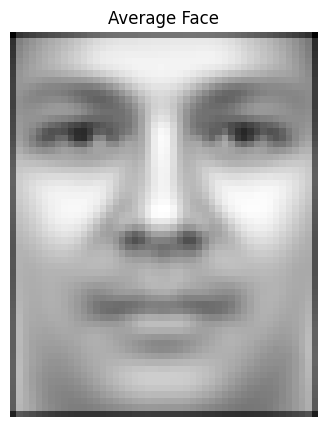

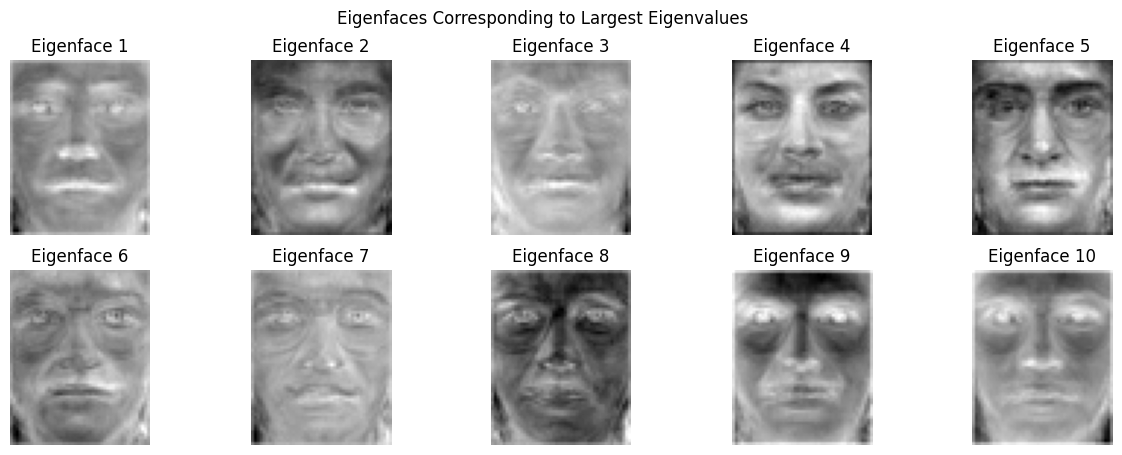

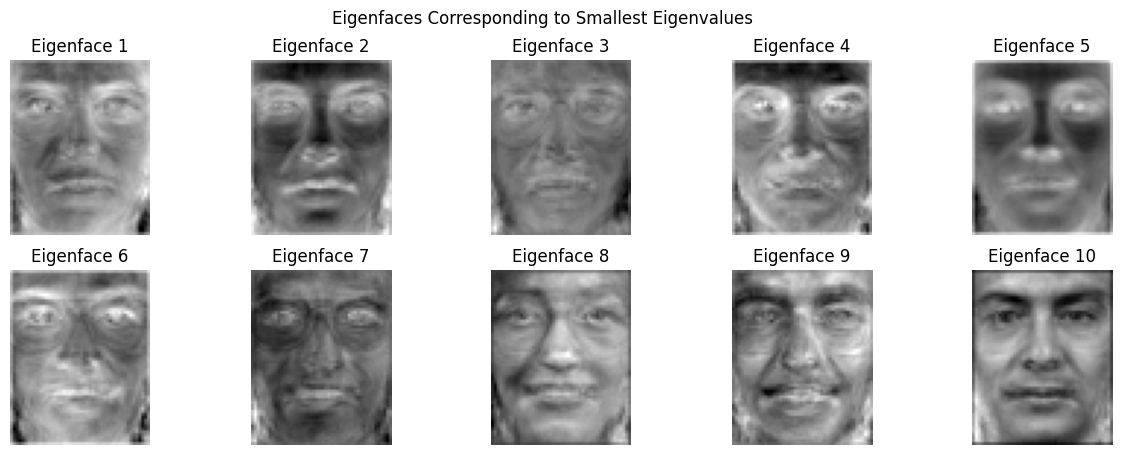

In [7]:
#reloads the image for mean face
face_image = []
for filename in files:
    img = Image.open(directory + '/fa_H/' + filename)
    imgArray = np.array(img)
    face_image.append(imgArray)

face_image = np.array(face_image)

average_face = np.mean(face_image,axis = 0)

plt.figure(figsize=(5, 5))
plt.imshow(average_face,cmap = 'gray')
plt.title('Average Face')
plt.axis('off')
plt.show()

#projects the eigenvector onto the data using the 10 largest eigenvectors
projectData = np.dot(facedata.T,EigenFaces.T).T
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    eigenface = projectData[i].reshape(average_face.shape[0],average_face.shape[1])
    plt.imshow(eigenface, cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')

plt.suptitle('Eigenfaces Corresponding to Largest Eigenvalues')
plt.show()

#projects the eigenvector onto the data using the 10 smallest eigenvectors
projectData = np.dot(facedata.T,EigenFaces.T).T
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    eigenface = projectData[projectData.shape[0]-i-1].reshape(average_face.shape[0],average_face.shape[1])
    plt.imshow(eigenface, cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')

plt.suptitle('Eigenfaces Corresponding to Smallest Eigenvalues')
plt.show()

In [62]:
#calculates the number of correct IDs  
def accuracy(testArray, experimentArray):
    positiveArray = []
    
    for i in range(testArray.shape[1]):
        positive = 0
        for j in range(testArray.shape[0]):
            for k in range(i):
                if testArray[j,k][:5] == experimentArray[j][:5]:
                    positive += 1
                    break
        positiveArray.append(positive)
    return positiveArray


In [9]:
K = int(EigenFaces.shape[1] * .8)

#Create the projection and Eigencov based on the number of data retention
projection = projectionTraining[:,:K]
EigenCov = (np.cov(projection.T))
EigenCovInverse = np.linalg.inv(EigenCov)
testFile = os.listdir(os.getcwd()+'/fb_H')

verifyArray = []

#loops through the test images and calculates the distance from range 1-50
for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_H/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,EigenFaces[:,:K])

    topMatches = []
    tempArray = files.copy()
    for j in range(EigenFaces.shape[1]):
        test = minDistanceTest(projection[j],testProjection,EigenCovInverse)
        topMatches.append(test[0,0])
    
    idx = np.argsort(topMatches)
    tempArray = np.array(tempArray)
    tempArray = tempArray.reshape(-1)
    tempArray = tempArray[idx]

    verifyArray.append(tempArray[:50])

verifyArray = np.array(verifyArray)
verifyArray = np.squeeze(verifyArray)

#compares the predicted ID to the actual ID and stores the results
test1 = accuracy(verifyArray, testFile)
test1 = np.array(test1)/len(testFile)


In [10]:
K = int(EigenFaces.shape[1] * .9)

#Create the projection and Eigencov based on the number of data retention
projection = projectionTraining[:,:K]
EigenCov = (np.cov(projection.T))
EigenCovInverse = np.linalg.inv(EigenCov)
testFile = os.listdir(os.getcwd()+'/fb_H')

verifyArray2 = []

#loops through the test images and calculates the distance from range 1-50
for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_H/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,EigenFaces[:,:K])

    topMatches = []
    
    tempArray = files.copy()
    
    for j in range(EigenFaces.shape[1]):
        test = minDistanceTest(projection[j],testProjection,EigenCovInverse)
        topMatches.append(test[0,0])
    
    idx = np.argsort(topMatches)
    tempArray = np.array(tempArray)
    tempArray = tempArray.reshape(-1)
    tempArray = tempArray[idx]
    verifyArray2.append(tempArray[:50])

verifyArray2 = np.array(verifyArray2)
verifyArray2 = np.squeeze(verifyArray2)

#compares the predicted ID to the actual ID and stores the results
test2 = accuracy(verifyArray2, testFile)
test2 = np.array(test2)/len(testFile)

In [11]:
K = int(EigenFaces.shape[1] * .95)

#Create the projection and Eigencov based on the number of data retention
projection = projectionTraining[:,:K]
EigenCov = (np.cov(projection.T))
EigenCovInverse = np.linalg.inv(EigenCov)
testFile = os.listdir(os.getcwd()+'/fb_H')

verifyArray3 = []

#loops through the test images and calculates the distance from range 1-50
for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_H/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,EigenFaces[:,:K])

    topMatches = []
    
    tempArray = files.copy()
    
    for j in range(EigenFaces.shape[1]):
        test = minDistanceTest(projection[j],testProjection,EigenCovInverse)
        topMatches.append(test[0,0])
    
    idx = np.argsort(topMatches)
    tempArray = np.array(tempArray)
    tempArray = tempArray.reshape(-1)
    tempArray = tempArray[idx]
    verifyArray3.append(tempArray[:50])

verifyArray3 = np.array(verifyArray3)
verifyArray3 = np.squeeze(verifyArray3)

#compares the predicted ID to the actual ID and stores the results
test3 = accuracy(verifyArray3, testFile)
test3 = np.array(test3)/len(testFile)

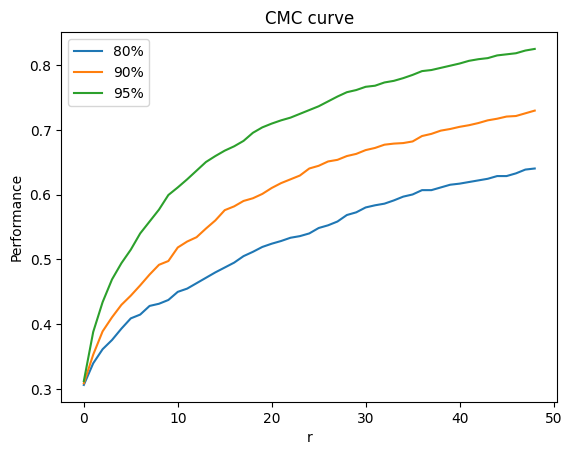

In [12]:
#displays the accuracy at differen range
plt.plot(test1[1:],label = '80%')
plt.plot(test2[1:], label = '90%')
plt.plot(test3[1:], label = '95%')
plt.xlabel('r')
plt.ylabel('Performance')
plt.title('CMC curve')
plt.legend()
plt.show()

In [13]:
#Display the faces from High resolution.
def displayFace(directory, filesTraining,fileTesting):
    img1 = Image.open(directory + '/fa_H/' + filesTraining)
    imgArray = np.array(img1)
    img2 = Image.open(directory + '/fb_H/' + fileTesting)
    imgArray2 = np.array(img2)
    
    return imgArray,imgArray2

In [57]:
#Display the faces from low resolution.
def displayFaceL(directory, filesTraining,fileTesting):
    img1 = Image.open(directory + '/fa_L/' + filesTraining)
    imgArray = np.array(img1)
    img2 = Image.open(directory + '/fb_L/' + fileTesting)
    imgArray2 = np.array(img2)
    
    return imgArray,imgArray2

In [52]:
#displays the first 3 cases of properly matched values for high resolutions
def displayMatches(verifyFile,testFile,percentage):
    requiredValue = 0
    count = 0
    positiveCount = []
    negativeCount = []
    for i in range(verifyArray.shape[0]):
        if requiredValue < 3:
            if verifyArray[i,0][:5] == testFile[i][:5]: 
                requiredValue+=1
                face1,face2 = (displayFace(directory,verifyArray[i,0],testFile[i]))
                positiveCount.append(face1)
                positiveCount.append(face2)
            else:
                face1,face2 = (displayFace(directory,verifyArray[i,0],testFile[i]))
                negativeCount.append(face1)
                negativeCount.append(face2)

    projectData = np.dot(facedata.T,EigenFaces.T).T

    plt.figure(figsize=(10, 5))

    for i in range(3):
        if i*2 < len(positiveCount):
            plt.subplot(2, 3, i + 1)
            plt.imshow(positiveCount[i * 2], cmap='gray')
            plt.title(f'Correct Match {i + 1} - Training')
            plt.axis('off')
    
            plt.subplot(2, 3, i + 4)
            plt.imshow(positiveCount[i * 2 + 1], cmap='gray')
            plt.title(f'Correct Match {i + 1} - Testing')
            plt.axis('off')
    plt.suptitle(f'Correct match given K = {percentage}')
    plt.show()

    plt.figure(figsize=(10, 5))

    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.imshow(negativeCount[i * 2], cmap='gray')
        plt.title(f'Incorrect Match {i + 1} - Training')
        plt.axis('off')

        plt.subplot(2, 3, i + 4)
        plt.imshow(negativeCount[i * 2 + 1], cmap='gray')
        plt.title(f'Incorrect Match {i + 1} - Testing')
        plt.axis('off')
    plt.suptitle(f'Incorrect match K = {percentage}')
    plt.tight_layout()
    plt.show()

In [63]:
#displays the first 3 cases of properly matched values for low resolutions
def displayMatchesL(verifyFile,testFile,percentage):
    requiredValue = 0
    count = 0
    positiveCount = []
    negativeCount = []
    for i in range(verifyArray.shape[0]):
        if requiredValue < 3:
            if verifyArray[i,0][:5] == testFile[i][:5]: 
                requiredValue+=1
                face1,face2 = (displayFaceL(directory,verifyArray[i,0],testFile[i]))
                positiveCount.append(face1)
                positiveCount.append(face2)
            else:
                face1,face2 = (displayFaceL(directory,verifyArray[i,0],testFile[i]))
                negativeCount.append(face1)
                negativeCount.append(face2)

    projectData = np.dot(facedata.T,EigenFaces.T).T

    plt.figure(figsize=(10, 5))

    for i in range(3):
        if i*2 < len(positiveCount):
            plt.subplot(2, 3, i + 1)
            plt.imshow(positiveCount[i * 2], cmap='gray')
            plt.title(f'Correct Match {i + 1} - Training')
            plt.axis('off')
    
            plt.subplot(2, 3, i + 4)
            plt.imshow(positiveCount[i * 2 + 1], cmap='gray')
            plt.title(f'Correct Match {i + 1} - Testing')
            plt.axis('off')
    plt.suptitle(f'Correct match given K = {percentage}')
    plt.show()

    plt.figure(figsize=(10, 5))

    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.imshow(negativeCount[i * 2], cmap='gray')
        plt.title(f'Incorrect Match {i + 1} - Training')
        plt.axis('off')

        plt.subplot(2, 3, i + 4)
        plt.imshow(negativeCount[i * 2 + 1], cmap='gray')
        plt.title(f'Incorrect Match {i + 1} - Testing')
        plt.axis('off')
    plt.suptitle(f'Incorrect match K = {percentage}')
    plt.tight_layout()
    plt.show()

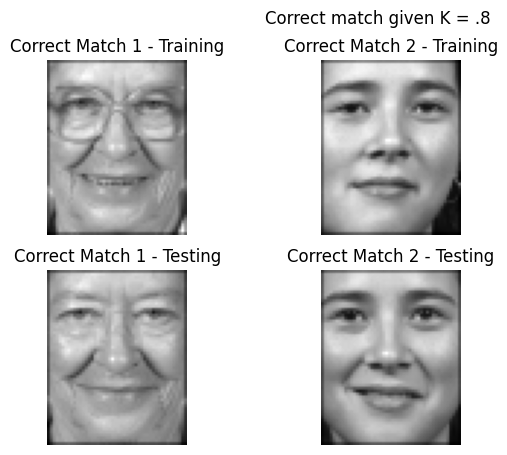

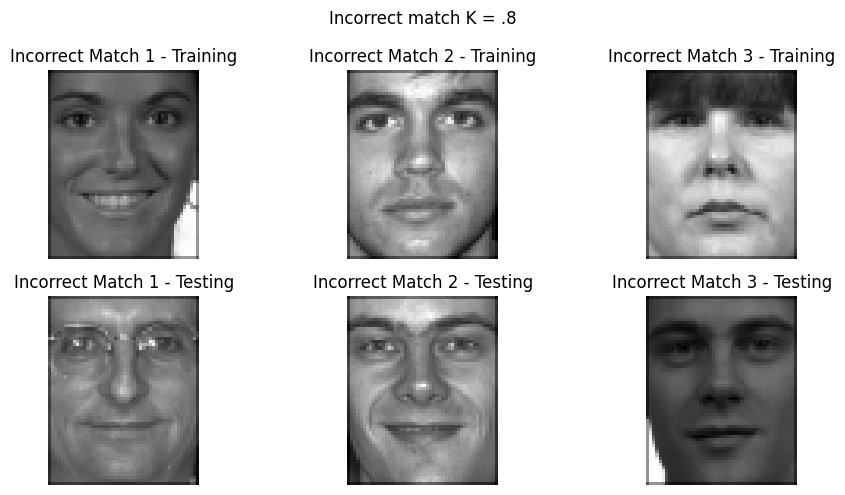

In [61]:
#displays high resolution at .8
displayMatches(verifyArray,testFile,'.8')

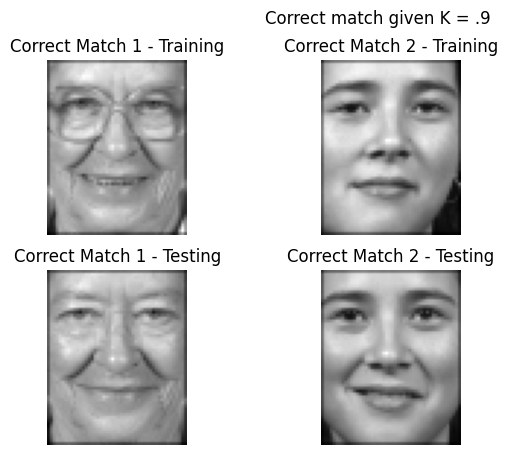

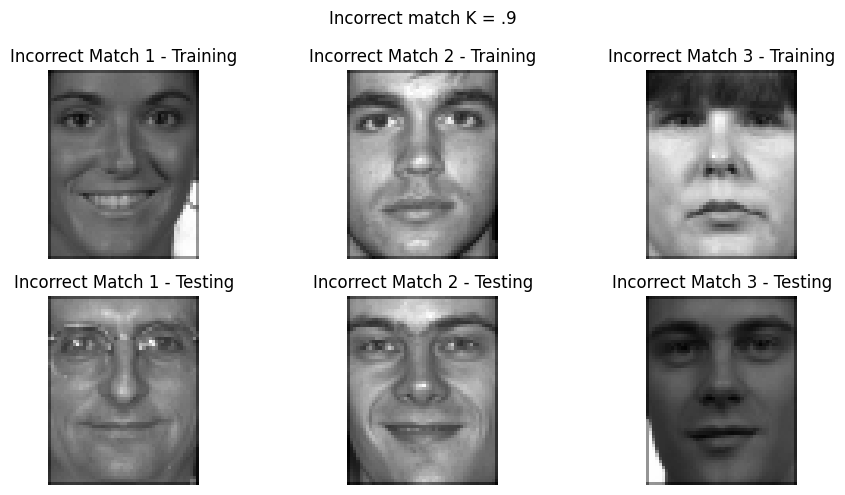

In [64]:
#displays high resolution at .9
displayMatches(verifyArray2,testFile,'.9')

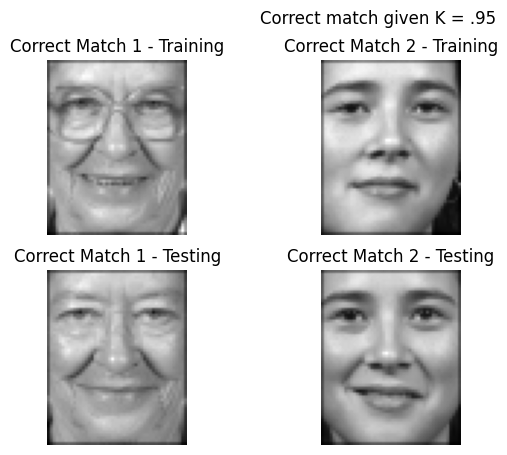

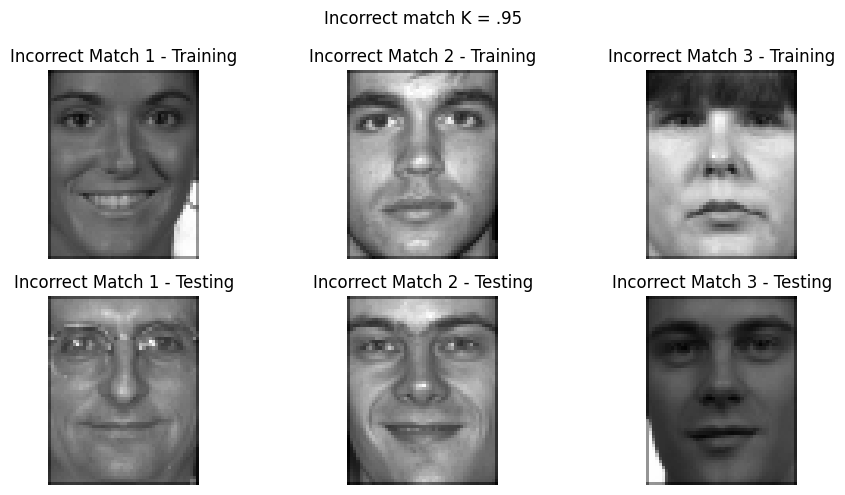

In [55]:
#displays high resolution at .95
displayMatches(verifyArray3,testFile,'.95')

In [28]:
#intruder detection
files = os.listdir(os.getcwd()+'/fa2_H')

trainingHash = HashTable(len(files))

#loads the image and creates a hashtable for ID of actual people
img1 = Image.open(directory + '/fa2_H/' + files[0])
pgm_array = np.array(img1)
facedataIntruder  = pgm_array.flatten()
facedataIntruder  = facedataIntruder.reshape(1,-1)
trainingHash[files[0][:5]] = True

for i in range(1,len(files)):
    img1 = Image.open(directory + '/fa2_H/' + files[i])
    pgm_array = np.array(img1)
    temp = pgm_array.flatten()
    temp = temp.reshape(1,-1)
    facedataIntruder  = np.append(facedataIntruder ,temp,axis = 0)
    trainingHash[files[i][:5]] = True

#checks for existing values
path = os.path.join(os.getcwd(),'meanFaceIntruder1.npy')
if(os.path.isfile(path)):
    meanFaceIntruder = np.load('meanFaceIntruder1.npy')
    EigenFacesIntruder = np.load('EigenFacesIntruder1.npy')
    projectionIntruder = np.load('projectionIntruder.npy')
    K = int(EigenFacesIntruder.shape[1] * .95)
    selectedDataIntruder = EigenFacesIntruder[:,:K]
    projectionIntruder = projectionIntruder[:,:K]
else:
    #calculates the mean face and centers the data
    meanFaceIntruder = np.mean(facedataIntruder )
    facedataIntruder  = facedataIntruder -meanFace
    originalDataIntruder  = np.array(facedataIntruder )

    #the ATA trick for step 3
    ataTrickIntruder  = np.dot(facedataIntruder ,facedataIntruder .T)

    #calculates the lamda and eigenvectors
    EigenValuesIntruder ,EigenFacesIntruder  = eigenCalculator(ataTrickIntruder )
    EigenFacesIntruder  = np.dot(facedataIntruder .T,EigenFacesIntruder )
    EigenFacesIntruder  /= np.linalg.norm(EigenFacesIntruder ,axis=0)

    #project the eigenvectors onto the data
    K = int(EigenFacesIntruder.shape[1] * .95)
    selectedDataIntruder = EigenFacesIntruder[:,:K]
    projectionIntruder = np.dot(facedataIntruder,selectedDataIntruder)

    np.save('meanFaceIntruder1.npy',meanFace)
    np.save('EigenFacesIntruder1.npy',EigenFaces)
    np.save('projectionIntruder.npy',projectionTraining)

EigenCovIntruder = (np.cov(projectionIntruder.T))
EigenCovInverseIntruder = np.linalg.inv(EigenCovIntruder)


In [30]:
verifyArrayIntruder = []
thresholdValue = []
Tr = 0

#calculates the smallest distance and stores the value
for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_H/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,selectedDataIntruder)

    topMatches = []
    
    tempArray = files.copy()
    
    for j in range(EigenFacesIntruder.shape[1]):
        test = minDistanceTest(projectionIntruder[j],testProjection,EigenCovInverseIntruder)
        topMatches.append(test[0,0])
        if(test > Tr):
            Tr = test
    
    idx = np.argsort(topMatches)
    thresholdValue.append(topMatches[idx[0]])
    #tempIntruder = np.array(tempIntruder)
    #tempIntruder = tempIntruder.reshape(-1)
    #tempIntruder = tempIntruder[idx]
    #verifyArrayIntruder.append(tempIntruder)

Tr = Tr[0,0]


In [31]:
#Counts the number of True positives and False postiives 
def rocCalc(threshold,test,hashtable,values):
    positive = 0
    negative = 0
    totalPositive =0
    totalNegative = 0
    for i in range(len(values)):
        if values[i] < threshold:
            if hashtable[test[i][:5]]:
                positive+=1
            else:
                negative+=1
        else:
            if hashtable[test[i][:5]]:
                totalPositive+=1
            else:
                totalNegative += 1


    totalNegative += negative
    totalPositive += positive

    truePositive = positive/totalPositive
    falsePositive = negative/totalNegative
    return truePositive,falsePositive

In [32]:
#creates interval of thresholds
interval = np.linspace(0,Tr,num=21)


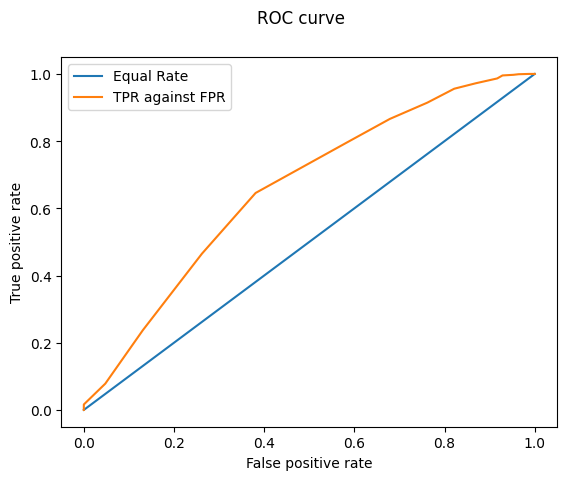

In [42]:
TPR = []
FPR = []

#for each threshold, count the values
for i in range(len(interval)):
    truePositive,falsePositive = rocCalc(interval[i],testFile,trainingHash,thresholdValue)
    TPR.append(truePositive)
    FPR.append(falsePositive)

x = [0,1]
y = [0,1]
plt.plot(x,y,label = 'Equal Rate')
plt.plot(FPR,TPR, label = 'TPR against FPR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.suptitle('ROC curve')
plt.show()

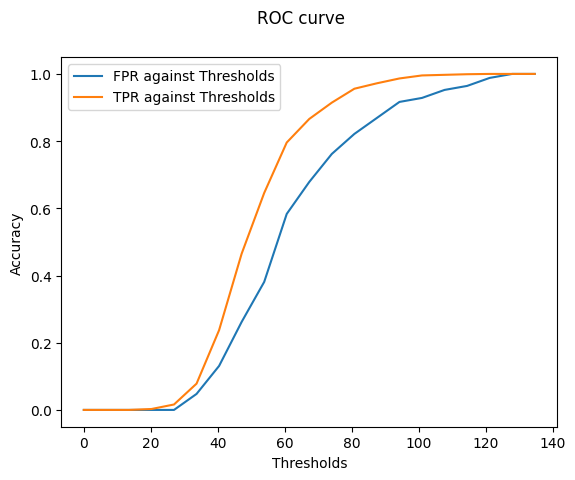

In [34]:

plt.plot(interval,FPR, label = 'FPR against Thresholds')
plt.plot(interval,TPR, label = 'TPR against Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('ROC curve')
plt.show()

In [35]:
#same code as first part, use FA_L folder instead for low resolution
directory = os.getcwd()
files = os.listdir(os.getcwd()+'/fa_L')


img1 = Image.open(directory + '/fa_L/' + files[0])
pgm_array = np.array(img1)
facedata = pgm_array.flatten()
facedata = facedata.reshape(1,-1)

for i in range(1,len(files)):
    img1 = Image.open(directory + '/fa_L/' + files[i])
    pgm_array = np.array(img1)
    temp = pgm_array.flatten()
    temp = temp.reshape(1,-1)
    facedata = np.append(facedata,temp,axis = 0)
    

path = os.path.join(os.getcwd(),'meanFaceL1.npy')

if(os.path.isfile(path)):
    meanFace = np.load('meanFaceL1.npy')
    EigenFaces = np.load('EigenfacesL1.npy')
    projectionTraining = np.load('projectionTrainingL1.npy')
else:
    meanFace = np.mean(facedata)
    facedata = facedata-meanFace
    originalData = np.array(facedata)

    ataTrick = np.dot(facedata,facedata.T)

    EigenValues,EigenFaces = eigenCalculator(ataTrick)
    EigenFaces = np.dot(facedata.T,EigenFaces)

    EigenFaces /= np.linalg.norm(EigenFaces,axis=0)

    projectionTraining = np.dot(facedata,EigenFaces)

    np.save('meanFaceL1.npy',meanFace)
    np.save('EigenfacesL1.npy',EigenFaces)
    np.save('projectionTrainingL1.npy',projectionTraining)

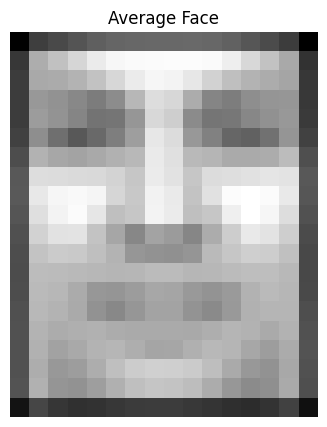

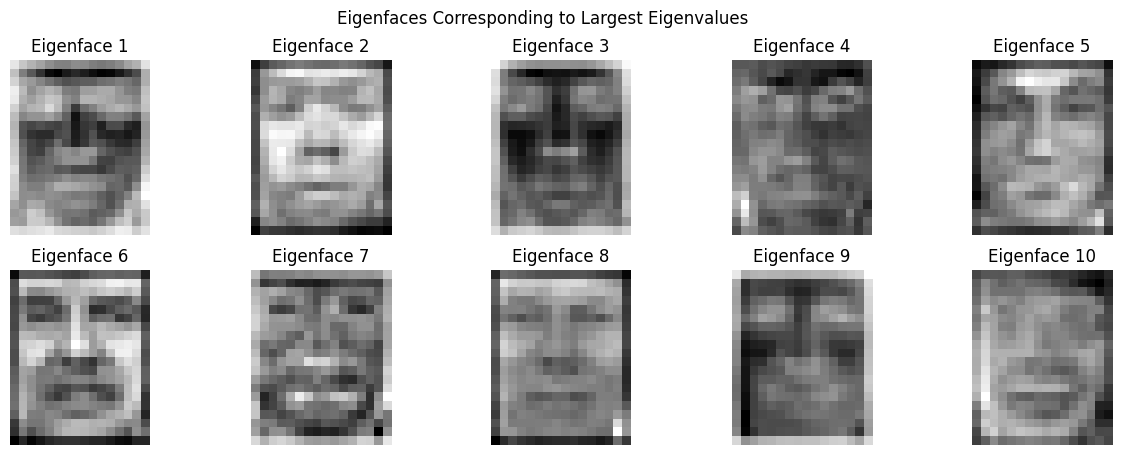

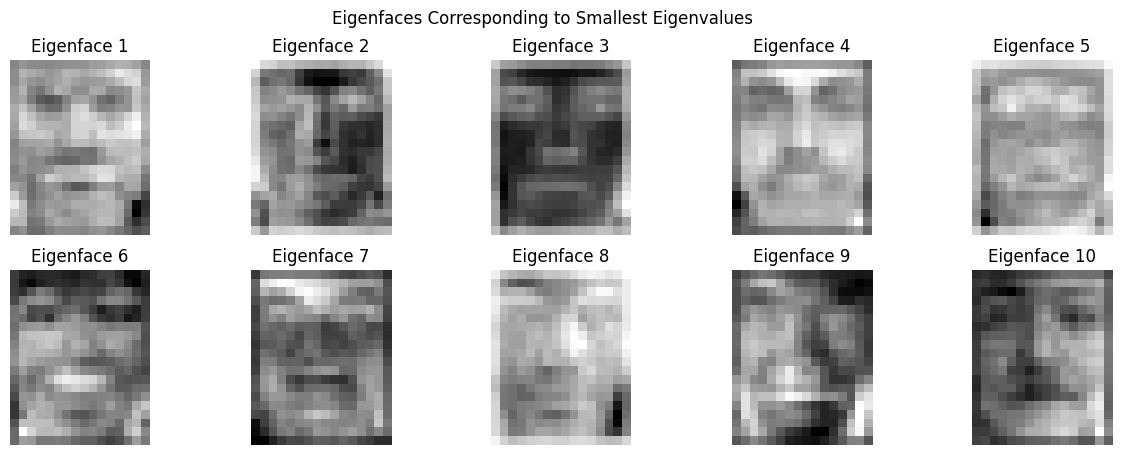

In [36]:
#same code as first part, use FA_L folder instead for low resolution
face_image = []
for filename in files:
    img = Image.open(directory + '/fa_L/' + filename)
    imgArray = np.array(img)
    face_image.append(imgArray)

face_image = np.array(face_image)

average_face = np.mean(face_image,axis = 0)

plt.figure(figsize=(5, 5))
plt.imshow(average_face,cmap = 'gray')
plt.title('Average Face')
plt.axis('off')
plt.show()

projectData = np.dot(facedata.T,EigenFaces.T).T
projectData = np.real(projectData)
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    eigenface = projectData[i].reshape(average_face.shape[0],average_face.shape[1])
    plt.imshow(eigenface, cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')

plt.suptitle('Eigenfaces Corresponding to Largest Eigenvalues')
plt.show()

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    eigenface = projectData[projectData.shape[0]-i-1].reshape(average_face.shape[0],average_face.shape[1])
    plt.imshow(eigenface, cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')

plt.suptitle('Eigenfaces Corresponding to Smallest Eigenvalues')
plt.show()

In [37]:
#same code as first part, use FA_L folder instead for low resolution
K = int(EigenFaces.shape[1] * .8)

projection = projectionTraining[:,:K]
EigenCov = (np.cov(projection.T))
EigenCovInverse = np.linalg.inv(EigenCov)
testFile = os.listdir(os.getcwd()+'/fb_L')

verifyArray = []


for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_L/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,EigenFaces[:,:K])

    topMatches = []
    tempArray = files.copy()
    for j in range(EigenFaces.shape[1]):
        test = minDistanceTest(projection[j],testProjection,EigenCovInverse)
        topMatches.append(test[0,0])
    
    idx = np.argsort(topMatches)
    tempArray = np.array(tempArray)
    tempArray = tempArray.reshape(-1)
    tempArray = tempArray[idx]

    verifyArray.append(tempArray[:50])

verifyArray = np.array(verifyArray)
verifyArray = np.squeeze(verifyArray)

test1 = accuracy(verifyArray, testFile)
test1 = np.array(test1)/len(testFile)


In [38]:
#same code as first part, use FA_L folder instead for low resolution
K = int(EigenFaces.shape[1] * .9)

projection = projectionTraining[:,:K]

EigenCov = (np.cov(projection.T))
EigenCovInverse = np.linalg.inv(EigenCov)
testFile = os.listdir(os.getcwd()+'/fb_L')

verifyArray2 = []


for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_L/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,EigenFaces[:,:K])

    topMatches = []
    
    tempArray = files.copy()
    
    for j in range(EigenFaces.shape[1]):
        test = minDistanceTest(projection[j],testProjection,EigenCovInverse)
        topMatches.append(test[0,0])
    
    idx = np.argsort(topMatches)
    tempArray = np.array(tempArray)
    tempArray = tempArray.reshape(-1)
    tempArray = tempArray[idx]
    verifyArray2.append(tempArray[:50])

verifyArray2 = np.array(verifyArray2)
verifyArray2 = np.squeeze(verifyArray2)


test2 = accuracy(verifyArray2, testFile)
test2 = np.array(test2)/len(testFile)

In [39]:
#same code as first part, use FA_L folder instead for low resolution
K = int(EigenFaces.shape[1] * .95)

projection = projectionTraining[:,:K]
EigenCov = (np.cov(projection.T))
EigenCovInverse = np.linalg.inv(EigenCov)
testFile = os.listdir(os.getcwd()+'/fb_L')

verifyArray3 = []


for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_L/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,EigenFaces[:,:K])

    topMatches = []
    
    tempArray = files.copy()
    
    for j in range(EigenFaces.shape[1]):
        test = minDistanceTest(projection[j],testProjection,EigenCovInverse)
        topMatches.append(test[0,0])
    
    idx = np.argsort(topMatches)
    tempArray = np.array(tempArray)
    tempArray = tempArray.reshape(-1)
    tempArray = tempArray[idx]
    verifyArray3.append(tempArray[:50])

verifyArray3 = np.array(verifyArray3)
verifyArray3 = np.squeeze(verifyArray3)

test3 = accuracy(verifyArray3, testFile)
test3 = np.array(test3)/len(testFile)

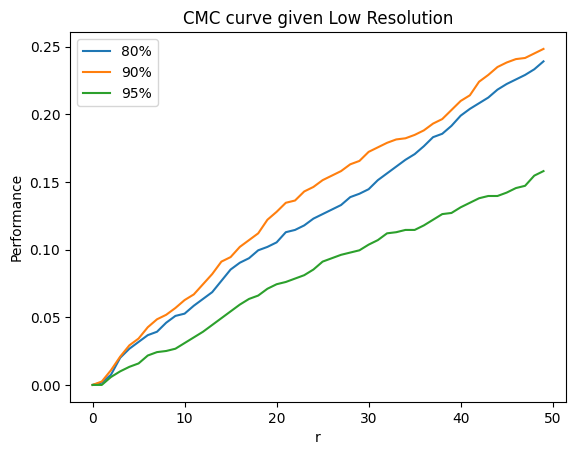

In [40]:
plt.plot(test1,label = '80%')
plt.plot(test2, label = '90%')
plt.plot(test3, label = '95%')
plt.xlabel('r')
plt.ylabel('Performance')
plt.title('CMC curve given Low Resolution')
plt.legend()
plt.show()

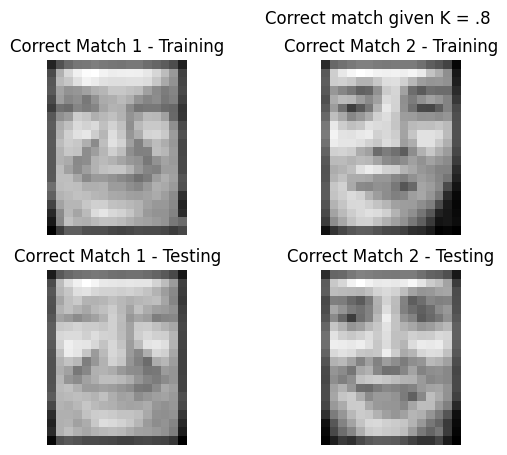

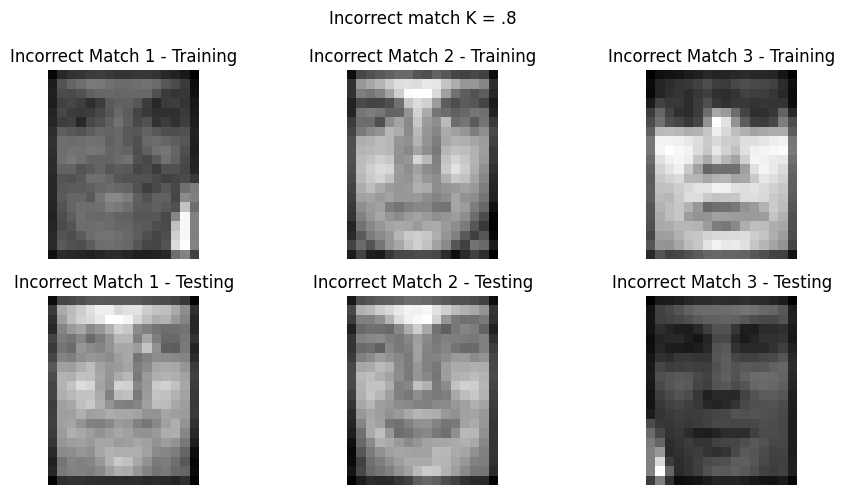

In [60]:
#same code as first part, use FA_L folder instead for low resolution
displayMatchesL(verifyArray,testFile,'.8')

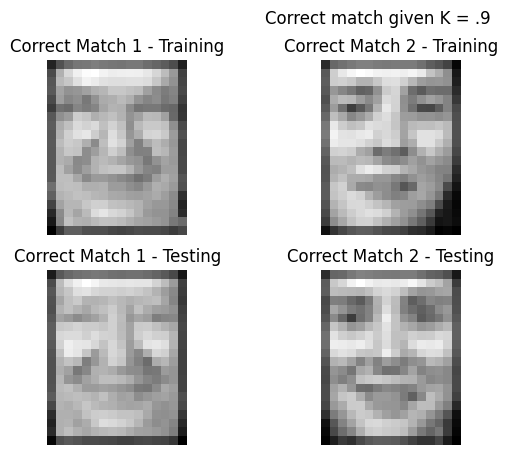

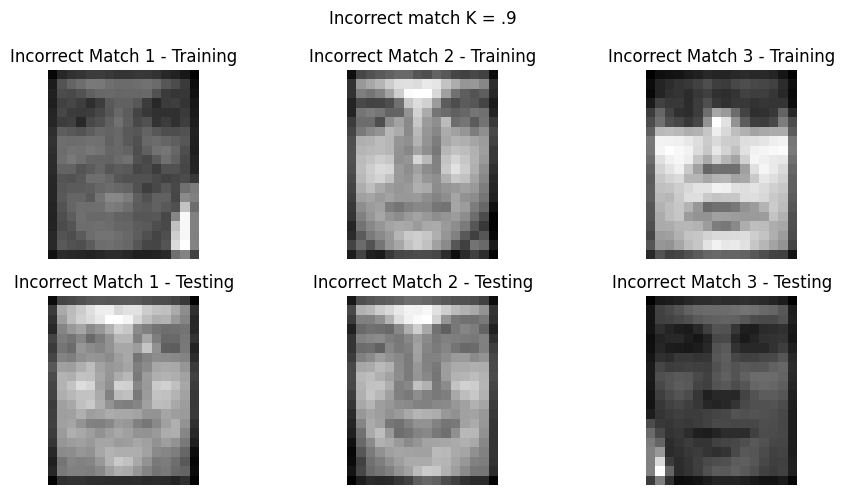

In [59]:
#same code as first part, use FA_L folder instead for low resolution
displayMatchesL(verifyArray2,testFile,'.9')

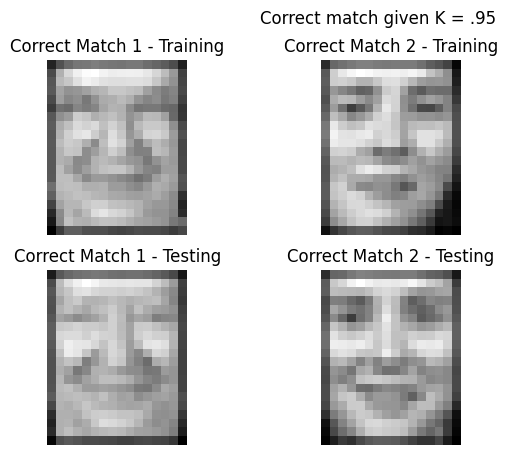

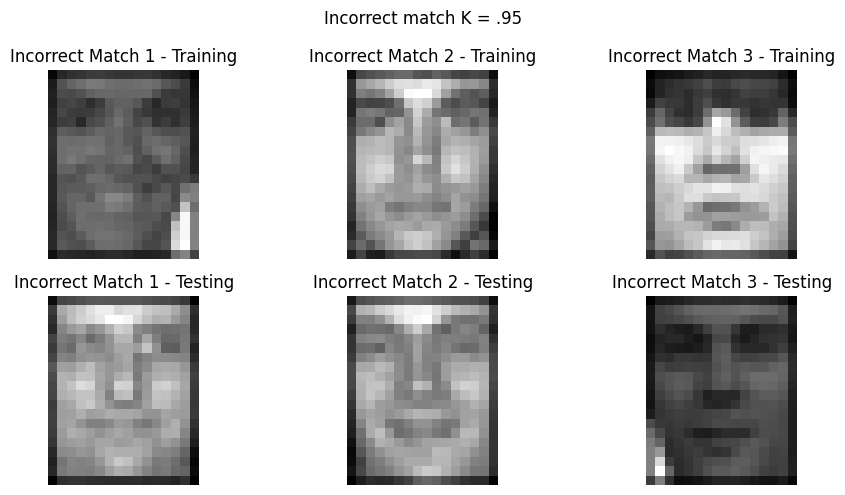

In [58]:
#same code as first part, use FA_L folder instead for low resolution
displayMatchesL(verifyArray3,testFile,'.95')

In [47]:
#same code as first part, use FA_L folder instead for low resolution
#intruder detection
files = os.listdir(os.getcwd()+'/fa2_L')

trainingHash = HashTable(len(files))

img1 = Image.open(directory + '/fa2_L/' + files[0])
pgm_array = np.array(img1)
facedataIntruder  = pgm_array.flatten()
facedataIntruder  = facedataIntruder.reshape(1,-1)
trainingHash[files[0][:5]] = True

for i in range(1,len(files)):
    img1 = Image.open(directory + '/fa2_L/' + files[i])
    pgm_array = np.array(img1)
    temp = pgm_array.flatten()
    temp = temp.reshape(1,-1)
    facedataIntruder  = np.append(facedataIntruder ,temp,axis = 0)
    trainingHash[files[i][:5]] = True


path = os.path.join(os.getcwd(),'meanFaceIntruderL1.npy')
if(os.path.isfile(path)):
    meanFaceIntruder = np.load('meanFaceIntruderL1.npy')
    EigenFacesIntruder = np.load('EigenFacesIntruderL1.npy')
    projectionIntruder = np.load('projectionIntruder.npy')
    K = int(EigenFacesIntruder.shape[1] * .95)
    selectedDataIntruder = EigenFacesIntruder[:,:K]
    projectionIntruder = projectionIntruder[:,:K]
else:
    meanFaceIntruder = np.mean(facedataIntruder )
    facedataIntruder  = facedataIntruder -meanFace
    originalDataIntruder  = np.array(facedataIntruder )

    ataTrickIntruder  = np.dot(facedataIntruder ,facedataIntruder .T)

    EigenValuesIntruder ,EigenFacesIntruder  = eigenCalculator(ataTrickIntruder )
    EigenFacesIntruder  = np.dot(facedataIntruder .T,EigenFacesIntruder )

    EigenFacesIntruder  /= np.linalg.norm(EigenFacesIntruder ,axis=0)


    K = int(EigenFacesIntruder.shape[1] * .95)
    selectedDataIntruder = EigenFacesIntruder[:,:K]

    projectionIntruder = np.dot(facedataIntruder,selectedDataIntruder)

    np.save('meanFaceIntruderL1.npy',meanFace)
    np.save('EigenFacesIntruderL1.npy',EigenFaces)
    np.save('projectionIntruderL.npy',projectionTraining)

EigenCovIntruder = (np.cov(projectionIntruder.T))
EigenCovInverseIntruder = np.linalg.inv(EigenCovIntruder)


In [49]:
#same code as first part, use FA_L folder instead for low resolution
verifyArrayIntruder = []
thresholdValue = []
Tr = 0

for i in range(len(testFile)):
    testImg = Image.open(directory + '/fb_L/' + testFile[i])
    pgm_test = np.array(testImg)
    testFace = pgm_test.flatten()
    testFace = testFace.reshape(1,-1)
    testFace = testFace-meanFace

    testProjection = np.dot(testFace,selectedDataIntruder)

    topMatches = []
    
    tempArray = files.copy()
    
    for j in range(EigenFacesIntruder.shape[1]):
        test = minDistanceTest(projectionIntruder[j],testProjection,EigenCovInverseIntruder)
        topMatches.append(test[0,0])
        if(test > Tr):
            Tr = test
    
    idx = np.argsort(topMatches)
    thresholdValue.append(topMatches[idx[0]])
    #tempIntruder = np.array(tempIntruder)
    #tempIntruder = tempIntruder.reshape(-1)
    #tempIntruder = tempIntruder[idx]
    #verifyArrayIntruder.append(tempIntruder)

Tr = Tr[0,0]

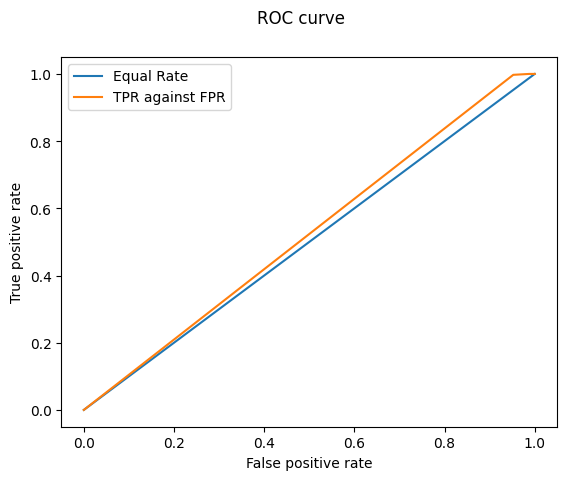

In [50]:
#same code as first part, use FA_L folder instead for low resolution
interval = np.linspace(0,Tr,num=21)
TPR = []
FPR = []

for i in range(len(interval)):
    truePositive,falsePositive = rocCalc(interval[i],testFile,trainingHash,thresholdValue)
    TPR.append(truePositive)
    FPR.append(falsePositive)

x = [0,1]
y = [0,1]
plt.plot(x,y,label = 'Equal Rate')
plt.plot(FPR,TPR, label = 'TPR against FPR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.suptitle('ROC curve')
plt.show()

C:\Users\Asi\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Asi\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


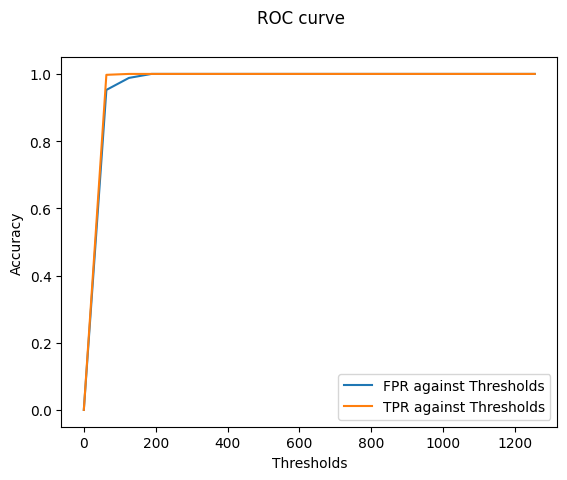

In [51]:
#same code as first part, use FA_L folder instead for low resolution
plt.plot(interval,FPR, label = 'FPR against Thresholds')
plt.plot(interval,TPR, label = 'TPR against Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('ROC curve')
plt.show()